<a href="https://colab.research.google.com/github/AlexBorealis/netology_tsml_hw/blob/master/kozlov_tsml_hw_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from scipy.stats import boxcox

In [78]:
series = pd.read_csv("monthly-boston-armed-robberies-j.csv")['Count']

def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag= 'AIC')
    dfoutput = pd.Series(dftest[0:4], index= ['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    dfoutput = dfoutput.to_frame().reset_index()
    dfoutput.columns = ['parameters', 'value']
    return dfoutput

def tsplot(y, lags= None, figsize= (12, 6), style= 'bmh', plot_name= None):
    print(test_stationarity(y))
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize= figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan= 2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax= ts_ax, color= 'blue', label= 'Or')
        ts_ax.set_title(plot_name)

        smt.graphics.plot_acf(y, lags= lags, ax= acf_ax, alpha= .05)
        smt.graphics.plot_pacf(y, lags= lags, ax= pacf_ax, alpha= .05)
        sm.qqplot(y, line= 's', ax= qq_ax)

        plt.tight_layout()
    return fig

                    parameters       value
0               Test Statistic    1.001102
1                      p-value    0.994278
2                    Lags Used   11.000000
3  Number of Observations Used  106.000000
4          Critical Value (1%)   -3.493602
5          Critical Value (5%)   -2.889217
6         Critical Value (10%)   -2.581533


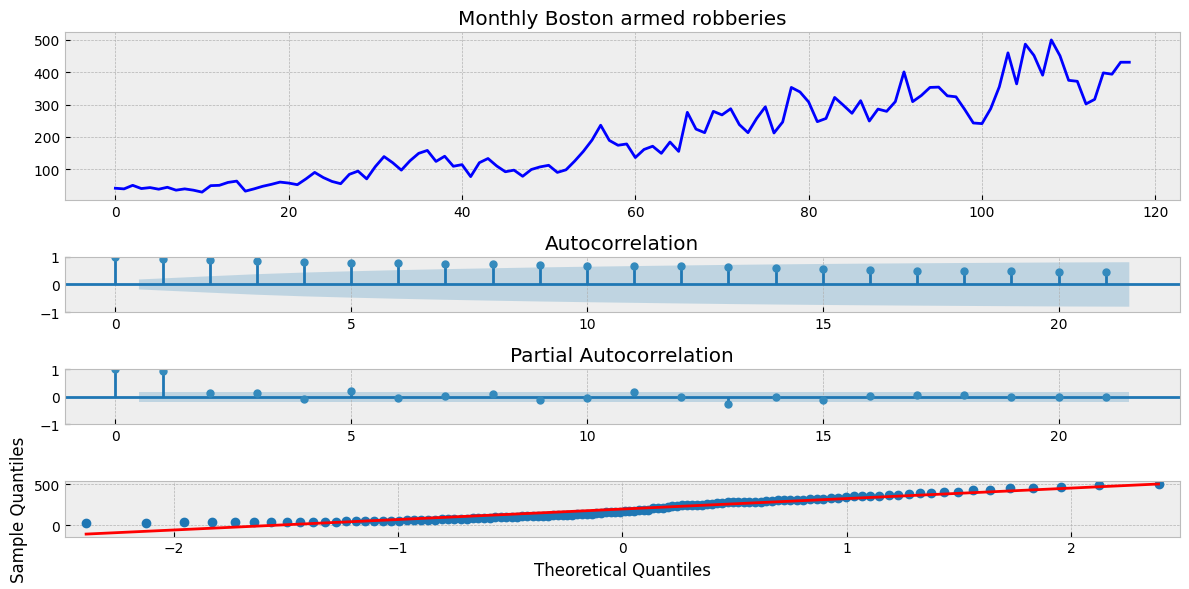

In [79]:
init_plot = tsplot(series, plot_name= 'Monthly Boston armed robberies')

                    parameters       value
0               Test Statistic   -0.876346
1                      p-value    0.795662
2                    Lags Used   11.000000
3  Number of Observations Used  106.000000
4          Critical Value (1%)   -3.493602
5          Critical Value (5%)   -2.889217
6         Critical Value (10%)   -2.581533


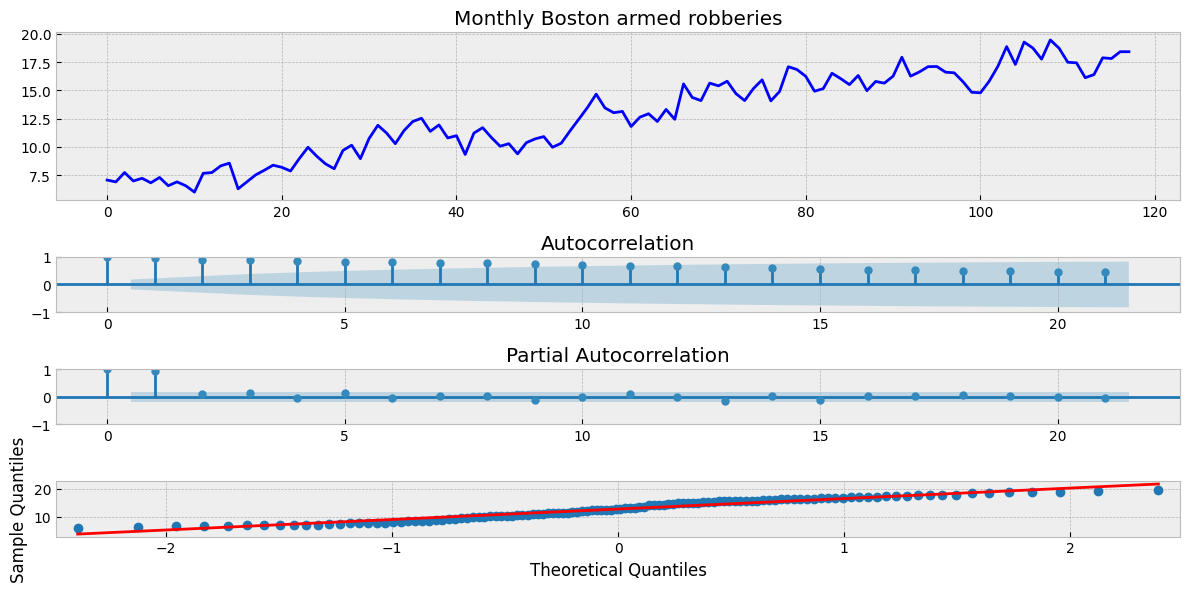

In [80]:
box_cox_series = boxcox(series)
box_cox_series_plot = tsplot(box_cox_series[0], plot_name= 'Monthly Boston armed robberies')

In [81]:
import warnings
warnings.filterwarnings("ignore")

best_aic = np.inf
best_order = None
best_season = None
best_mdl = None

for p in range(5):
    for d in range(1, 5):
        for q in range(5):
            for s in range(3):
                try:
                    tmp_mdl = smt.ARIMA(box_cox_series[0],
                                        order= (p, d, q),
                                        seasonal_order= (0, 0, 0, s),
                                        trend= 't').fit(method= 'innovations_mle')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (p, d, q)
                        best_season = s
                        best_mdl = tmp_mdl
                except: continue

In [82]:
print('aic: {:6.5f} | order: {} | season: {}'.format(best_aic, best_order, best_season))

aic: 315.28377 | order: (1, 1, 1) | season: 2


                    parameters         value
0               Test Statistic -1.354744e+01
1                      p-value  2.446016e-25
2                    Lags Used  0.000000e+00
3  Number of Observations Used  1.170000e+02
4          Critical Value (1%) -3.487517e+00
5          Critical Value (5%) -2.886578e+00
6         Critical Value (10%) -2.580124e+00


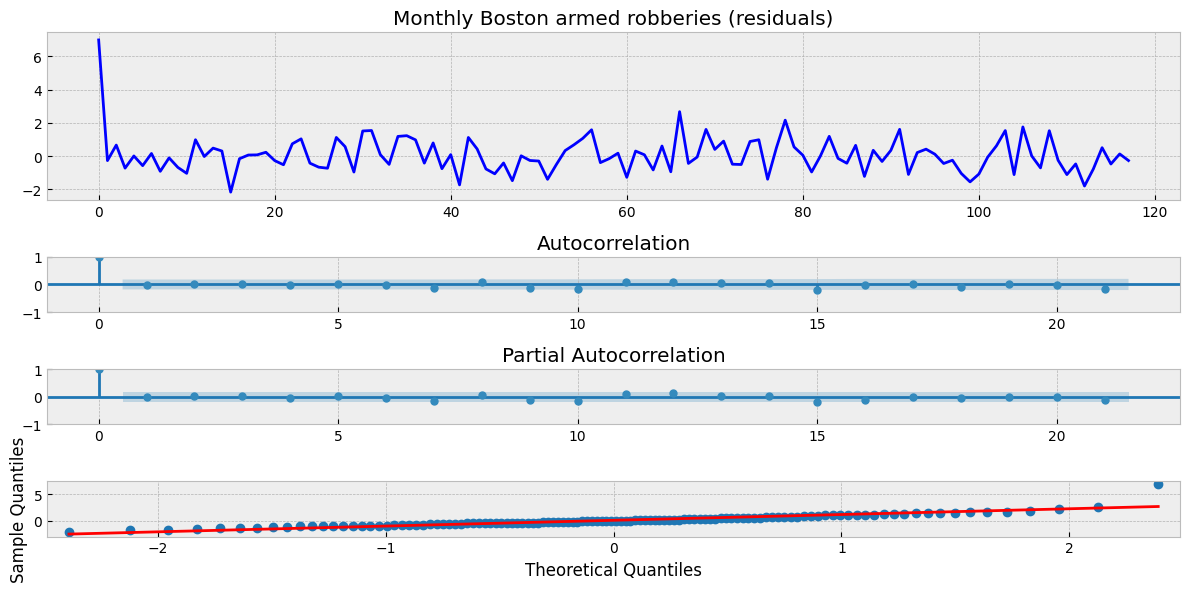

In [83]:
residuals_plot = tsplot(best_mdl.resid, plot_name= 'Monthly Boston armed robberies (residuals)')

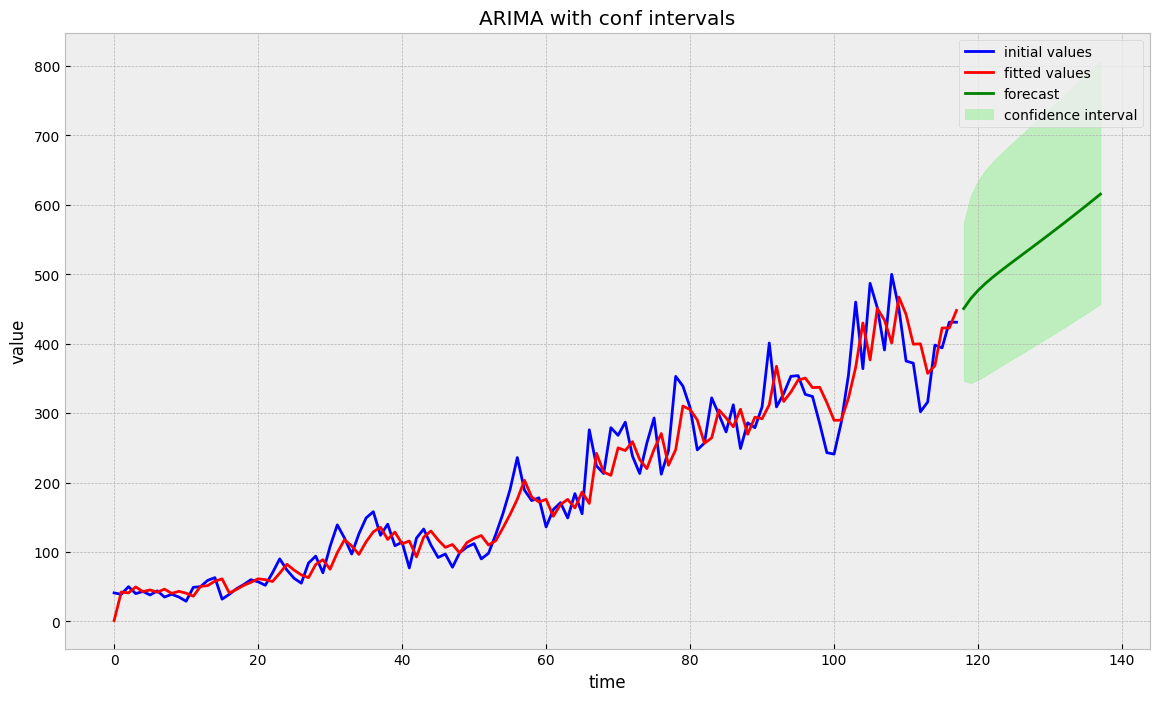

In [84]:
with plt.style.context('bmh'):
    plt.figure(figsize= (14, 8))
    ax = plt.axes()

    forecast = best_mdl.get_forecast(steps= 20)
    forecast_index = np.arange(len(series), len(series) + 20)

    forecast_fitted = (best_mdl.fittedvalues * box_cox_series[1] + 1) ** (1 / box_cox_series[1])
    forecast_values = (forecast.predicted_mean * box_cox_series[1] + 1) ** (1 / box_cox_series[1])

    conf_int_boxcox = forecast.conf_int()
    if box_cox_series[1] != 0:
        conf_int_original = ((conf_int_boxcox * box_cox_series[1] + 1) ** (1 / box_cox_series[1]))
    else:
        conf_int_original = np.exp(conf_int_boxcox)

    plt.plot(series, color= 'blue', label= 'initial values')
    plt.plot(forecast_fitted, color= 'red', label= 'fitted values')
    plt.plot(forecast_index, forecast_values, color= 'green', label= 'forecast')

    plt.fill_between(forecast_index,
                     conf_int_original[:, 0],
                     conf_int_original[:, 1],
                     color='lightgreen', alpha= .5, label= 'confidence interval')

    plt.xlabel('time')
    plt.ylabel('value')
    plt.title('ARIMA with conf intervals')
    plt.legend()
    plt.show()